# This notebook must be run with the Vizgen_2 conda environment within the Vizgen.sif singularity container

In [1]:
import scanpy as sc
import pandas as pd
import os
import string
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import Mapping
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial

import skimage
import cv2
from skimage.morphology import disk, opening, closing
from scipy.ndimage import binary_fill_holes, label, distance_transform_edt
from skimage.segmentation import find_boundaries, watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from skimage.segmentation import watershed
import anndata
from adjustText import adjust_text

import Mapping
import os
import string

import cv2
import geopandas as gpd
import igraph as ig
#import leidenalg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import tifffile
import umap
from anndata import AnnData as ad
from matplotlib import patches as mpatches
#from matplotlib_scalebar.scalebar import ScaleBar
import scanpy as sc
import anndata
from shapely.affinity import translate
from shapely.geometry import Polygon, MultiPolygon, box, shape
from skimage import img_as_bool, img_as_ubyte
from skimage.measure import find_contours, regionprops, regionprops_table
from skimage.morphology import skeletonize, opening
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from skimage.segmentation import find_boundaries
from tqdm import tqdm
import matplotlib.patches as patches



/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-13 12:19:30.029054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 12:19:30.047650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 12:19:30.053403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 12:19:30.068721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFl

/tmp/ipykernel_1426461/3202746309.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad_parent.obs['gene_counts'] = gene_counts_per_cell
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


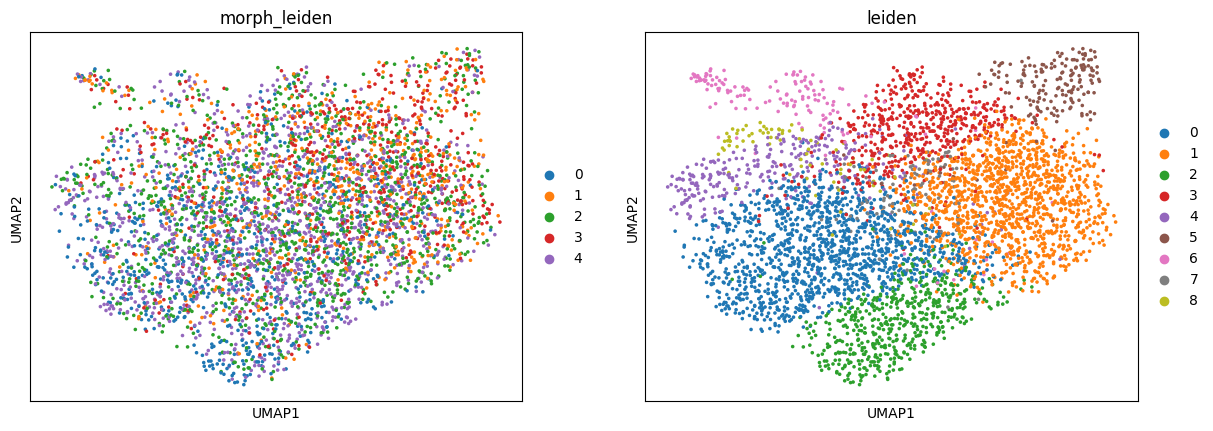

In [13]:
ad_parent = sc.read_h5ad('../03_morph_embedding/Shape_500.h5ad')
ad_parent = ad_parent[ad_parent.obs.updated_celltype == 'Microglia']
ad_parent.X = ad_parent.layers['counts'].todense().copy()
gene_counts_per_cell = np.count_nonzero(np.asarray(ad_parent.X.todense()), axis=1)
ad_parent.obs['gene_counts'] = gene_counts_per_cell

ad_list = []
for batch in ad_parent.obs.batchID.unique():
    ad_viz = ad_parent[ad_parent.obs.batchID == batch].copy()
    
    total = pd.read_csv(f"transcript_out/{batch}_nuc_y_non_nuc.csv",index_col=0)
    non_nuc = pd.read_csv(f"transcript_out/{batch}_non_nuc.csv",index_col=0)
    
    ad_viz.layers['total_counts'] = total[ad_viz.var_names.intersection(total.columns)].to_numpy()
    ad_viz.layers['non_nuc_counts'] = non_nuc[ad_viz.var_names.intersection(non_nuc.columns)].to_numpy()
    
    ad_viz.layers['nuc_counts'] = ad_viz.layers['total_counts'] - ad_viz.layers['non_nuc_counts']
    
    ad_list.append(ad_viz)
    
combined_adata = anndata.concat(ad_list, axis=0)

adata = combined_adata.copy()
adata.X = adata.layers['total_counts'].copy()
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata,random_state=42)
sc.tl.leiden(adata,resolution=0.7,random_state=42)
sc.pl.umap(adata, color=["morph_leiden","leiden"])

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


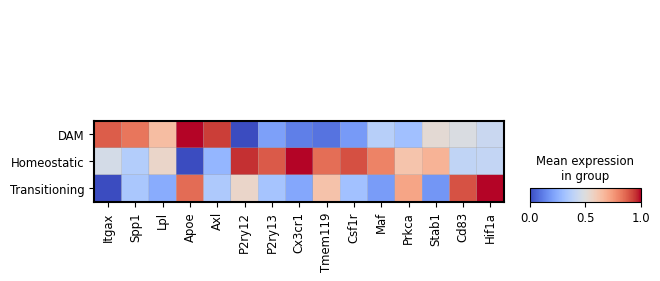

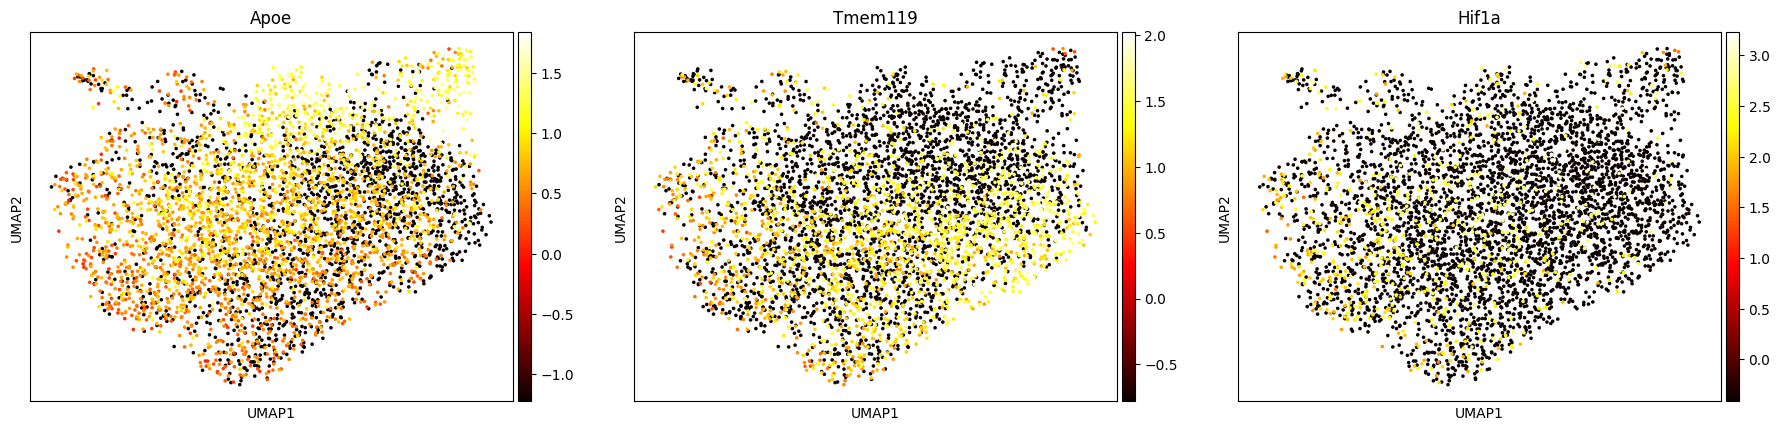

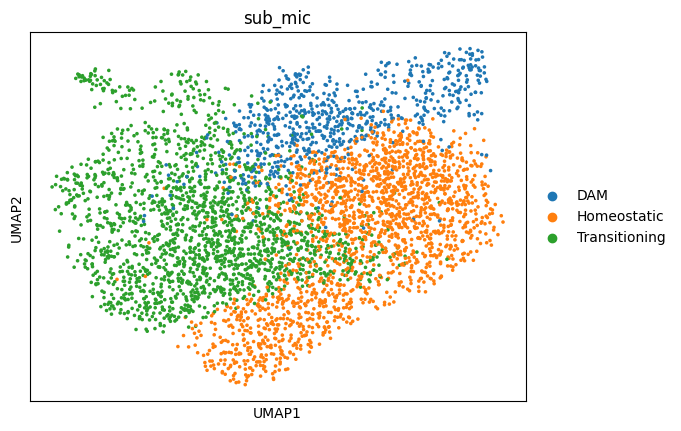

In [14]:
new_ad = adata.copy()
new_ad.X = new_ad.layers['total_counts'].copy()
sc.pp.normalize_total(new_ad, target_sum=1e4)
sc.pp.log1p(new_ad)

clusters = {
    '0':'Transitioning',
    '1':'Homeostatic',
    '2':'Homeostatic',
    '3':'DAM',
    '4':'Transitioning',
    '5':'DAM',
    '6':'Transitioning',
    '7':'Homeostatic',
    '8':'Transitioning',
}
new_ad.obs['sub_mic'] = new_ad.obs['leiden'].map(clusters)

sc.pl.matrixplot(new_ad,groupby='sub_mic',standard_scale='group',cmap='coolwarm',var_names=['Itgax','Spp1','Lpl','Apoe','Axl','P2ry12','P2ry13','Cx3cr1','Tmem119','Csf1r'
                                                                         ,'Maf','Prkca','Stab1','Cd83','Hif1a'], save='_clusters.pdf')

sc.pl.umap(new_ad, color=["Apoe","Tmem119","Hif1a"],cmap='hot',save='_hot_genes.png')
sc.pl.umap(new_ad, color=["sub_mic"],save='_clusters.png')

# Example Images

In [15]:
mosaic_to_micron = pd.read_csv('/hpc/projects/group.quake/doug/Shapes_Spatial/3-mo-female-1-rev2/images/micron_to_mosaic_pixel_transform.csv',delimiter=' ').iloc[0,1]

In [16]:
def plot_random_cells_from_cluster(data, cluster_id,column='leiden', num_cells=9,raw=False,random_state=35, conversion_rate=1.0, micron_length=50, output_pdf=None):
    """
    Plot random cells from the specified Leiden cluster.
    
    Args:
    - data (pd.DataFrame): DataFrame containing 'batchID', 'cell_label', and 'leiden_cluster'.
    - cluster_id (int): The Leiden cluster ID to visualize.
    - num_cells (int): Number of cells to display, default is 4.
    """
    # Filter data for the specified cluster
    cluster_data = data[data[column] == cluster_id]
    #print(cluster_data)
    
    # Randomly select cells if there are more than num_cells
    if len(cluster_data) > num_cells:
        cluster_data = cluster_data.sample(n=num_cells, random_state=random_state)
    
    # Create a grid plot
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    axes = axes.flatten()
    
    for ax, (_, row) in zip(axes, cluster_data.iterrows()):
        print(row['batchID'])
        image = load_label_image(row['batchID'], row['x'], row['y'], raw)
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Batch: {row['batchID']}, x: {row['x']}, y:{row['y']}")
        add_scale_bar(ax, conversion_rate, micron_length, location=(10, image.shape[0] - 20))
    
    plt.tight_layout()
    
    if output_pdf:
        plt.savefig(output_pdf, format='pdf', bbox_inches='tight')
    plt.show()

In [19]:
def plot_random_cells_from_cluster(data, cluster_id,column='leiden', num_cells=9,raw=False,random_state=35, conversion_rate=1.0, micron_length=50, output_pdf=None):
    """
    Plot random cells from the specified Leiden cluster.
    
    Args:
    - data (pd.DataFrame): DataFrame containing 'batchID', 'cell_label', and 'leiden_cluster'.
    - cluster_id (int): The Leiden cluster ID to visualize.
    - num_cells (int): Number of cells to display, default is 4.
    """
    # Filter data for the specified cluster
    cluster_data = data[data[column] == cluster_id]
    #print(cluster_data)
    
    # Randomly select cells if there are more than num_cells
    if len(cluster_data) > num_cells:
        cluster_data = cluster_data.sample(n=num_cells, random_state=random_state)
    
    # Create a grid plot
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    axes = axes.flatten()
    
    for ax, (_, row) in zip(axes, cluster_data.iterrows()):
        print(row['batchID'])
        image = load_label_image(row['batchID'], row['x'], row['y'], raw)
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Batch: {row['batchID']}, x: {row['x']}, y:{row['y']}")
        add_scale_bar(ax, conversion_rate, micron_length, location=(10, image.shape[0] - 20))
    
    plt.tight_layout()
    
    if output_pdf:
        plt.savefig(output_pdf, format='pdf', bbox_inches='tight')
    plt.show()
    
def extract_sub_image_with_padding(image, bbox, padding=10):
    min_row, min_col, max_row, max_col = bbox
    min_row = max(min_row - padding, 0)
    min_col = max(min_col - padding, 0)
    max_row = min(max_row + padding, image.shape[0])
    max_col = min(max_col + padding, image.shape[1])
    return image[min_row:max_row, min_col:max_col], (min_row, min_col)

def add_scale_bar(ax, conversion_rate, micron_length, color='red', location=(10, 10), thickness=50, fontsize=12):
    """
    Add a scale bar to the given axis.

    Args:
    - ax: The axis on which to draw the scale bar.
    - conversion_rate: The pixel-to-micron conversion factor (pixels per micron).
    - micron_length: The length of the scale bar in microns.
    - color: The color of the scale bar.
    - location: A tuple specifying the (x, y) location of the scale bar.
    - thickness: The thickness of the scale bar in pixels.
    """
    # Calculate the length of the scale bar in pixels
    pixel_length = conversion_rate * micron_length
    
    # Create a rectangle for the scale bar
    scale_bar = patches.Rectangle(location, pixel_length, thickness, linewidth=0, edgecolor=color, facecolor=color)
    
    # Add the scale bar to the plot
    ax.add_patch(scale_bar)
    text_x = location[0] + pixel_length + 10  # Place text to the right of the scale bar
    text_y = location[1] + thickness / 2      # Vertically center the text with the scale bar
    ax.text(text_x, text_y, f'{micron_length} μm', color=color, fontsize=fontsize, va='center')


def load_label_image(batchID, x_ax, y_ax,raw=False):
    root = '/hpc/projects/group.quake/doug/Shapes_Spatial/'
    
    transform_file = f'{root}{batchID}/images/micron_to_mosaic_pixel_transform.csv'
    transform_df = pd.read_table(transform_file, sep=' ', header=None)
    transformation_matrix = transform_df.values
    
    x_ax = round(x_ax * transformation_matrix[0,0] + transformation_matrix[0,2])
    y_ax = round(y_ax * transformation_matrix[1,1] + transformation_matrix[1,2])
    
    print(f'load {batchID}')
    raw_im = Mapping.load_tiff_image(root + batchID + '/binary_image.tif')
    
    box_size = 500
    x_start = x_ax - box_size
    x_end = x_ax + box_size
    y_start = y_ax - box_size
    y_end = y_ax + box_size
    
    # Extract the sub-image, ensuring the indices are within bounds
    sub_image = np.zeros((2*box_size, 2*box_size), dtype=raw_im.dtype)
    
    raw_x_start = max(x_start, 0)
    raw_x_end = min(x_end, raw_im.shape[1])
    raw_y_start = max(y_start, 0)
    raw_y_end = min(y_end, raw_im.shape[0])
    
    sub_x_start = max(0, -x_start)
    sub_x_end = sub_x_start + (raw_x_end - raw_x_start)
    sub_y_start = max(0, -y_start)
    sub_y_end = sub_y_start + (raw_y_end - raw_y_start)
    
    sub_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end] = raw_im[raw_y_start:raw_y_end, raw_x_start:raw_x_end]
    
    if raw==True:
        return sub_image
    
    #sub_test = raw_im[(y_ax-500):(y_ax+500), (x_ax-500):(x_ax+500)]
    #print(sub_test.shape)
    
    #if sub_test.size == 0:
     #   return np.zeros((20,20))
    
    subtract = cv2.fastNlMeansDenoising(sub_image)
    pre = cv2.adaptiveThreshold((255 - subtract), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 75, 2)

    opened = opening(255 - pre, disk(3))
    pre = closing(opened, disk(3))

    filled_image = binary_fill_holes(pre)

    labeled_array, num_features = label(filled_image)
    
    point = (500, 500)

    regions = regionprops(labeled_array)

    largest_component_label = None
    max_area = 0

    for region in regions:
        if region.area > 500:
            # Find the boundary of the component
            boundary = find_boundaries(labeled_array == region.label, mode='outer')
            boundary_coords = np.column_stack(np.where(boundary))

            # Calculate the distance from the point to the boundary
            distances = np.linalg.norm(boundary_coords - np.array(point), axis=1)
            min_dist = np.min(distances)

            if min_dist < 100:
                if region.area > max_area:
                    max_area = region.area
                    largest_component_label = region.label

    if largest_component_label is not None:
        isolated_component = labeled_array == largest_component_label

        label_image = np.zeros_like(labeled_array)
        label_image[isolated_component] = 1
        return label_image
        
    return sub_image

24-mo-male-2
load 24-mo-male-2
24-mo-female-5
load 24-mo-female-5
24-mo-female-1
load 24-mo-female-1
24-mo-female-3
load 24-mo-female-3
24-mo-female-5
load 24-mo-female-5
3-mo-female-1-rev2
load 3-mo-female-1-rev2
24-mo-female-3
load 24-mo-female-3
24-mo-female-3
load 24-mo-female-3
24-mo-male-4-rev2
load 24-mo-male-4-rev2


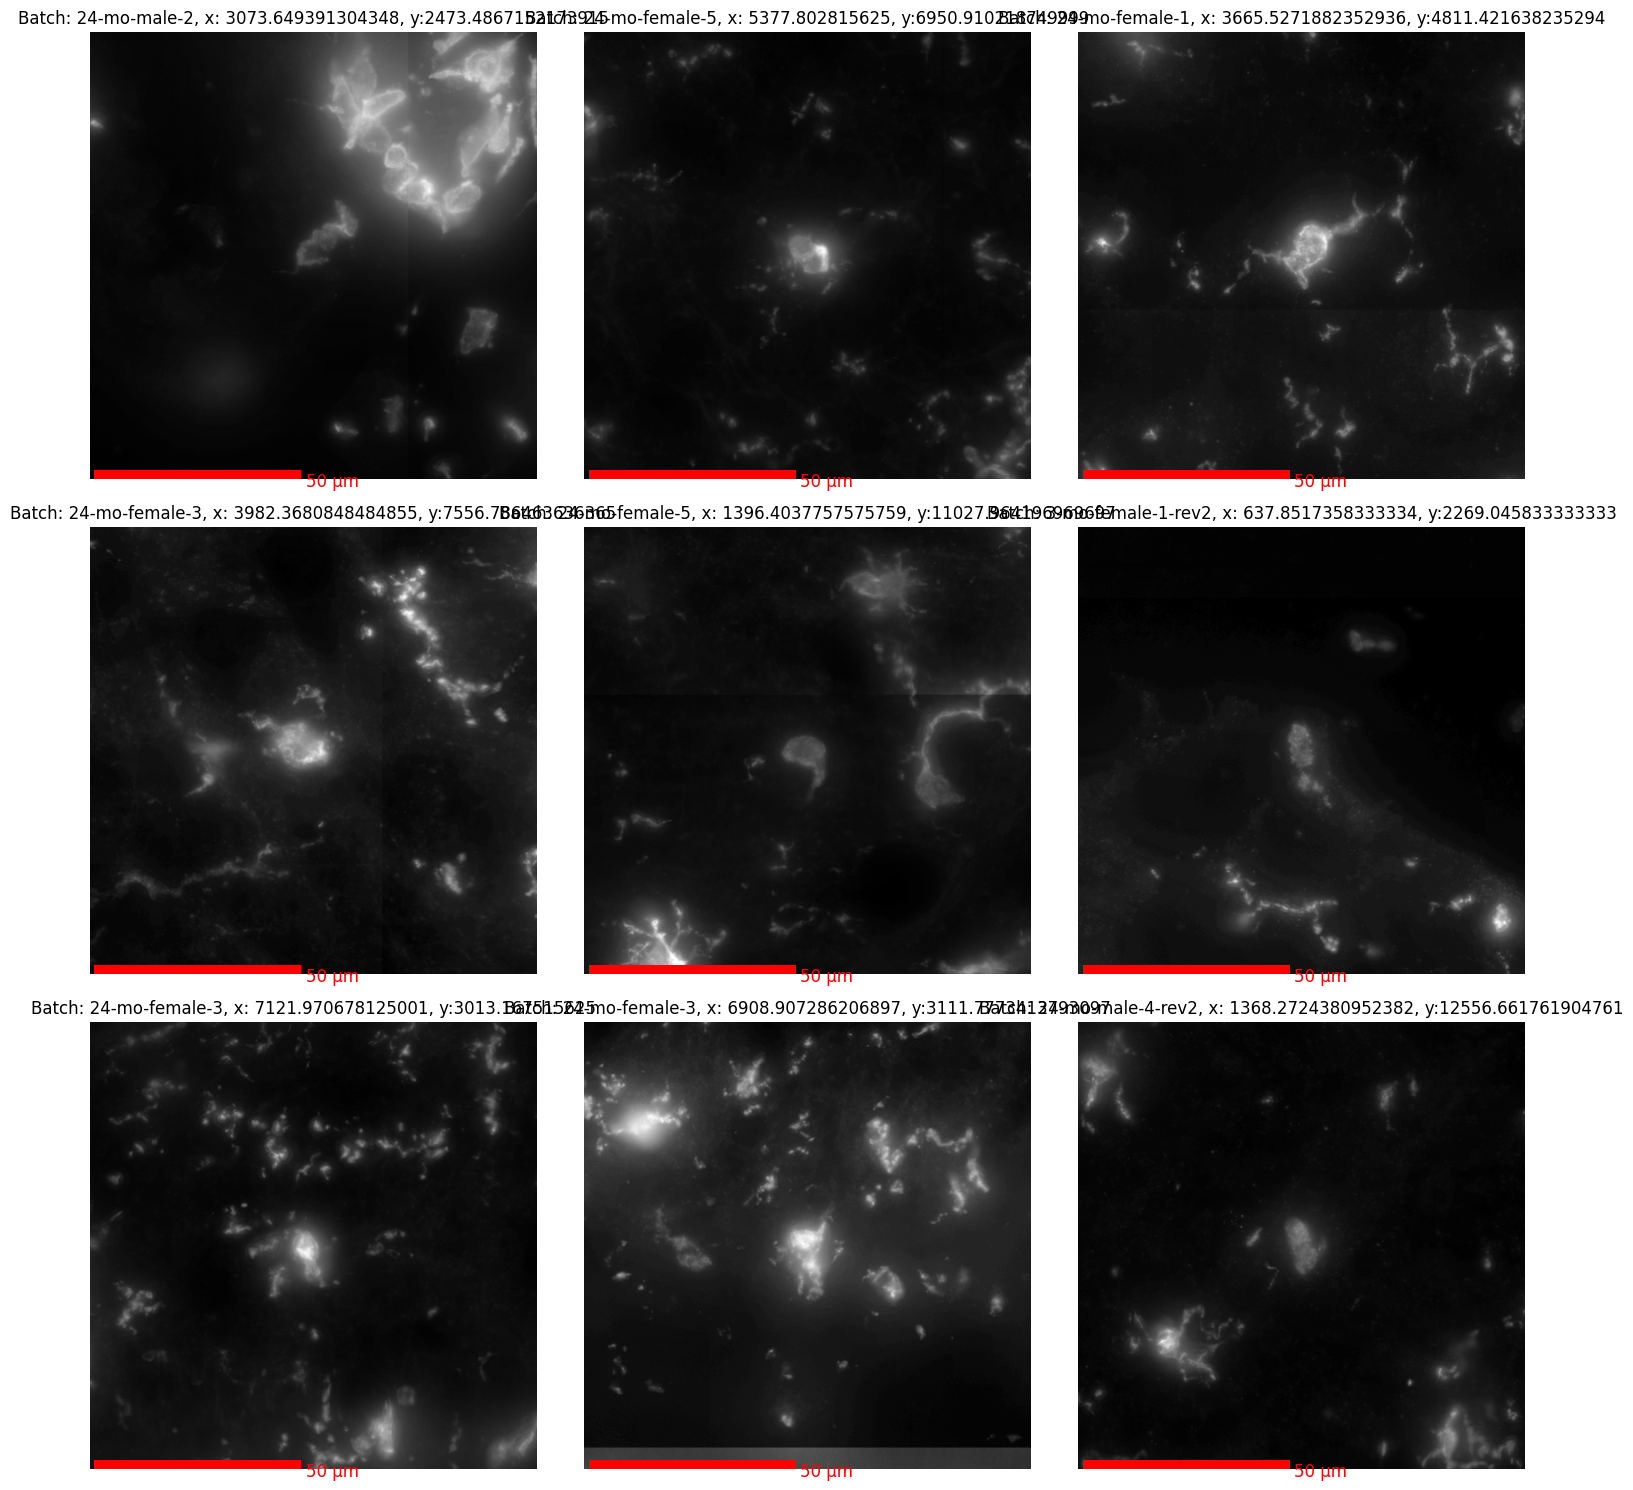

In [20]:
plot_random_cells_from_cluster(new_ad.obs, cluster_id='DAM', column='sub_mic', raw=True,random_state=10,conversion_rate=mosaic_to_micron,output_pdf='figures/DAM_examples.pdf')

24-mo-female-5
load 24-mo-female-5
3-mo-male-2
load 3-mo-male-2
3-mo-female-3
load 3-mo-female-3
3-mo-female-1-rev2
load 3-mo-female-1-rev2
3-mo-female-1-rev2
load 3-mo-female-1-rev2
3-mo-male-3-rev2
load 3-mo-male-3-rev2
24-mo-female-5
load 24-mo-female-5
3-mo-female-3
load 3-mo-female-3
3-mo-male-3-rev2
load 3-mo-male-3-rev2


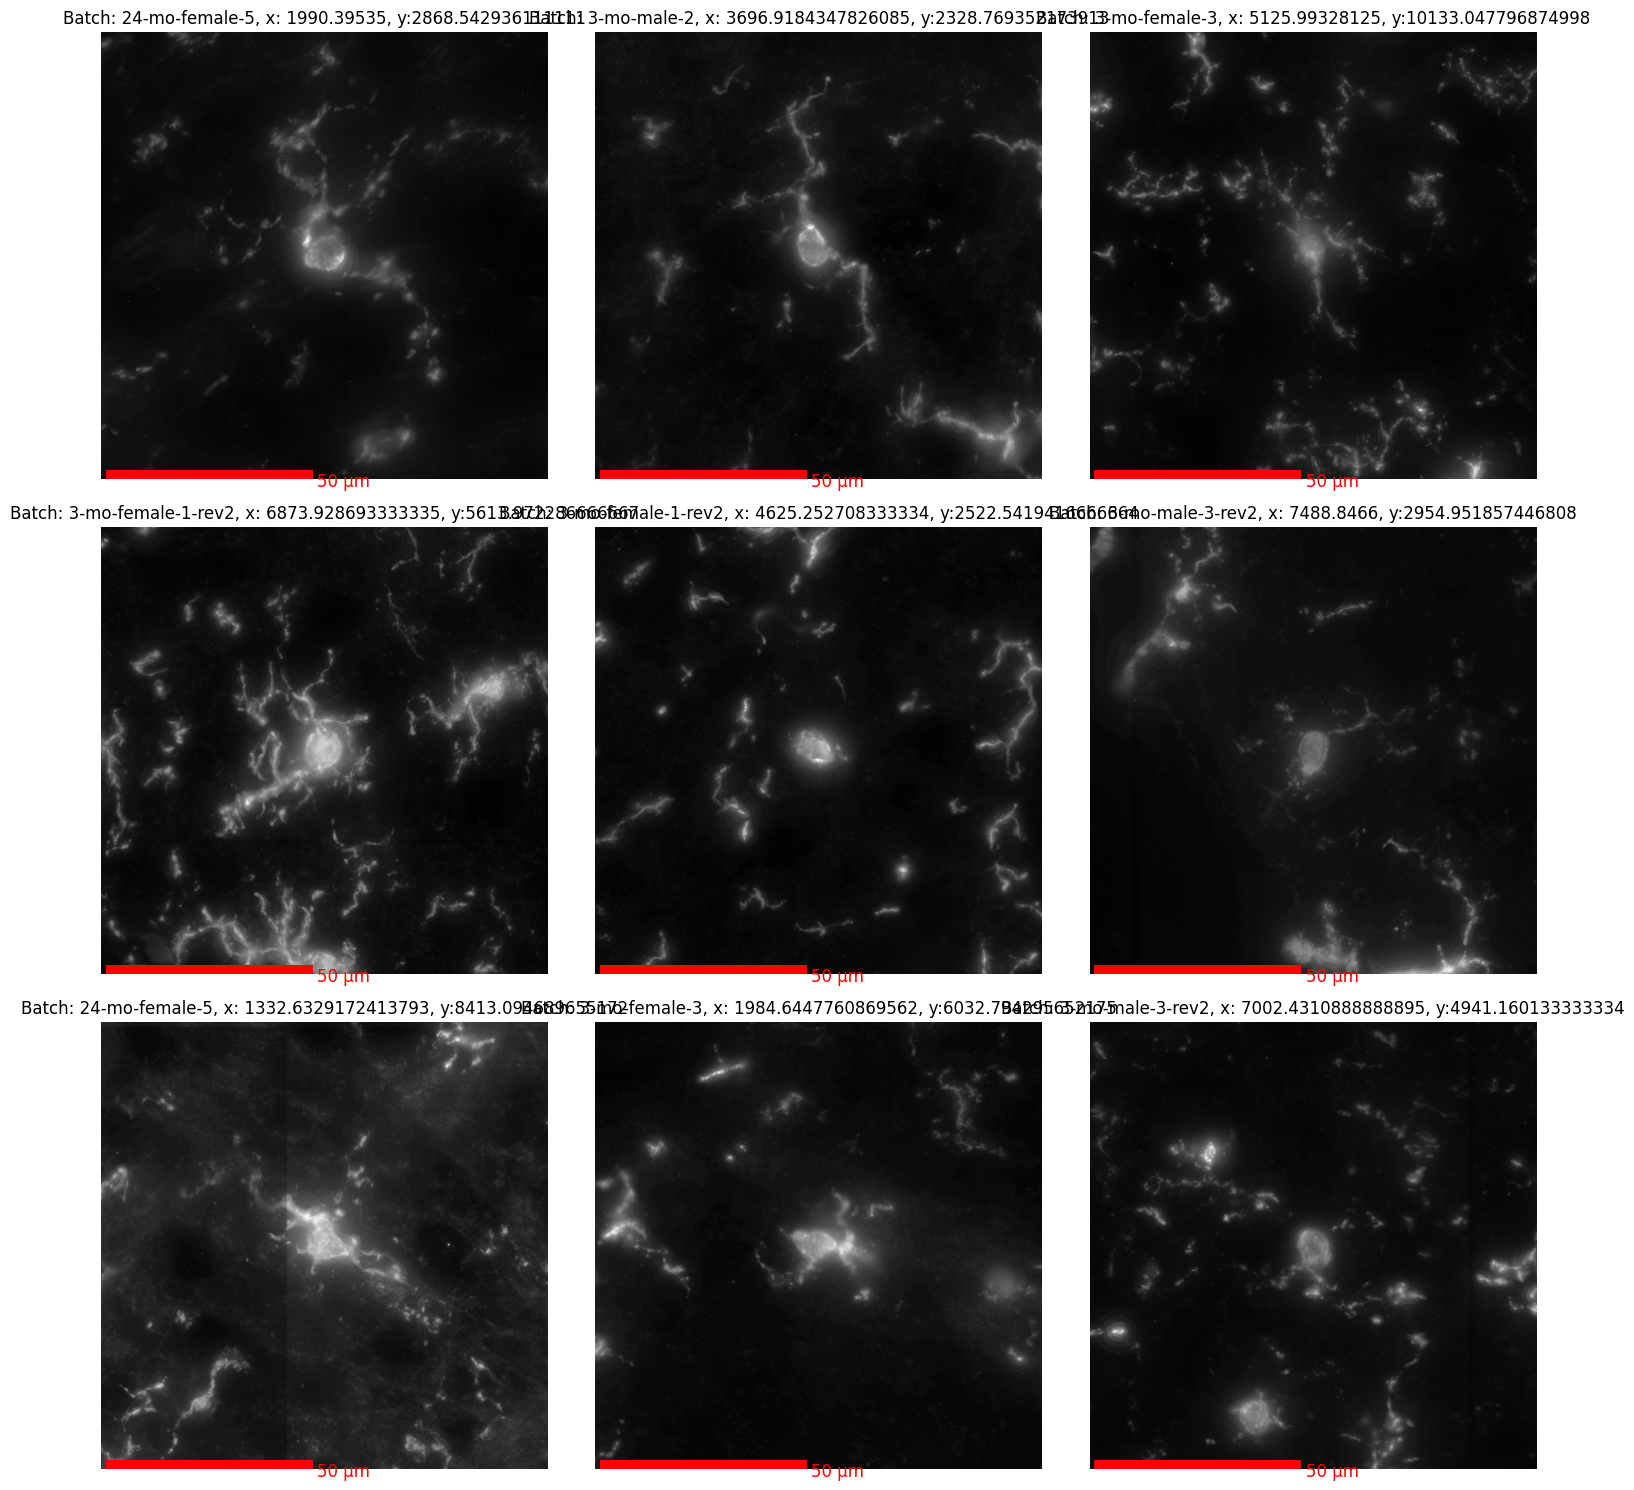

In [21]:
plot_random_cells_from_cluster(new_ad.obs, cluster_id='Homeostatic', column='sub_mic', raw=True,conversion_rate=mosaic_to_micron,output_pdf='figures/Homeostatic_examples.pdf')

3-mo-female-3
load 3-mo-female-3
3-mo-female-3
load 3-mo-female-3
24-mo-female-5
load 24-mo-female-5
3-mo-male-1
load 3-mo-male-1
24-mo-female-1
load 24-mo-female-1
3-mo-female-3
load 3-mo-female-3
24-mo-female-3
load 24-mo-female-3
3-mo-female-1-rev2
load 3-mo-female-1-rev2
3-mo-male-3-rev2
load 3-mo-male-3-rev2


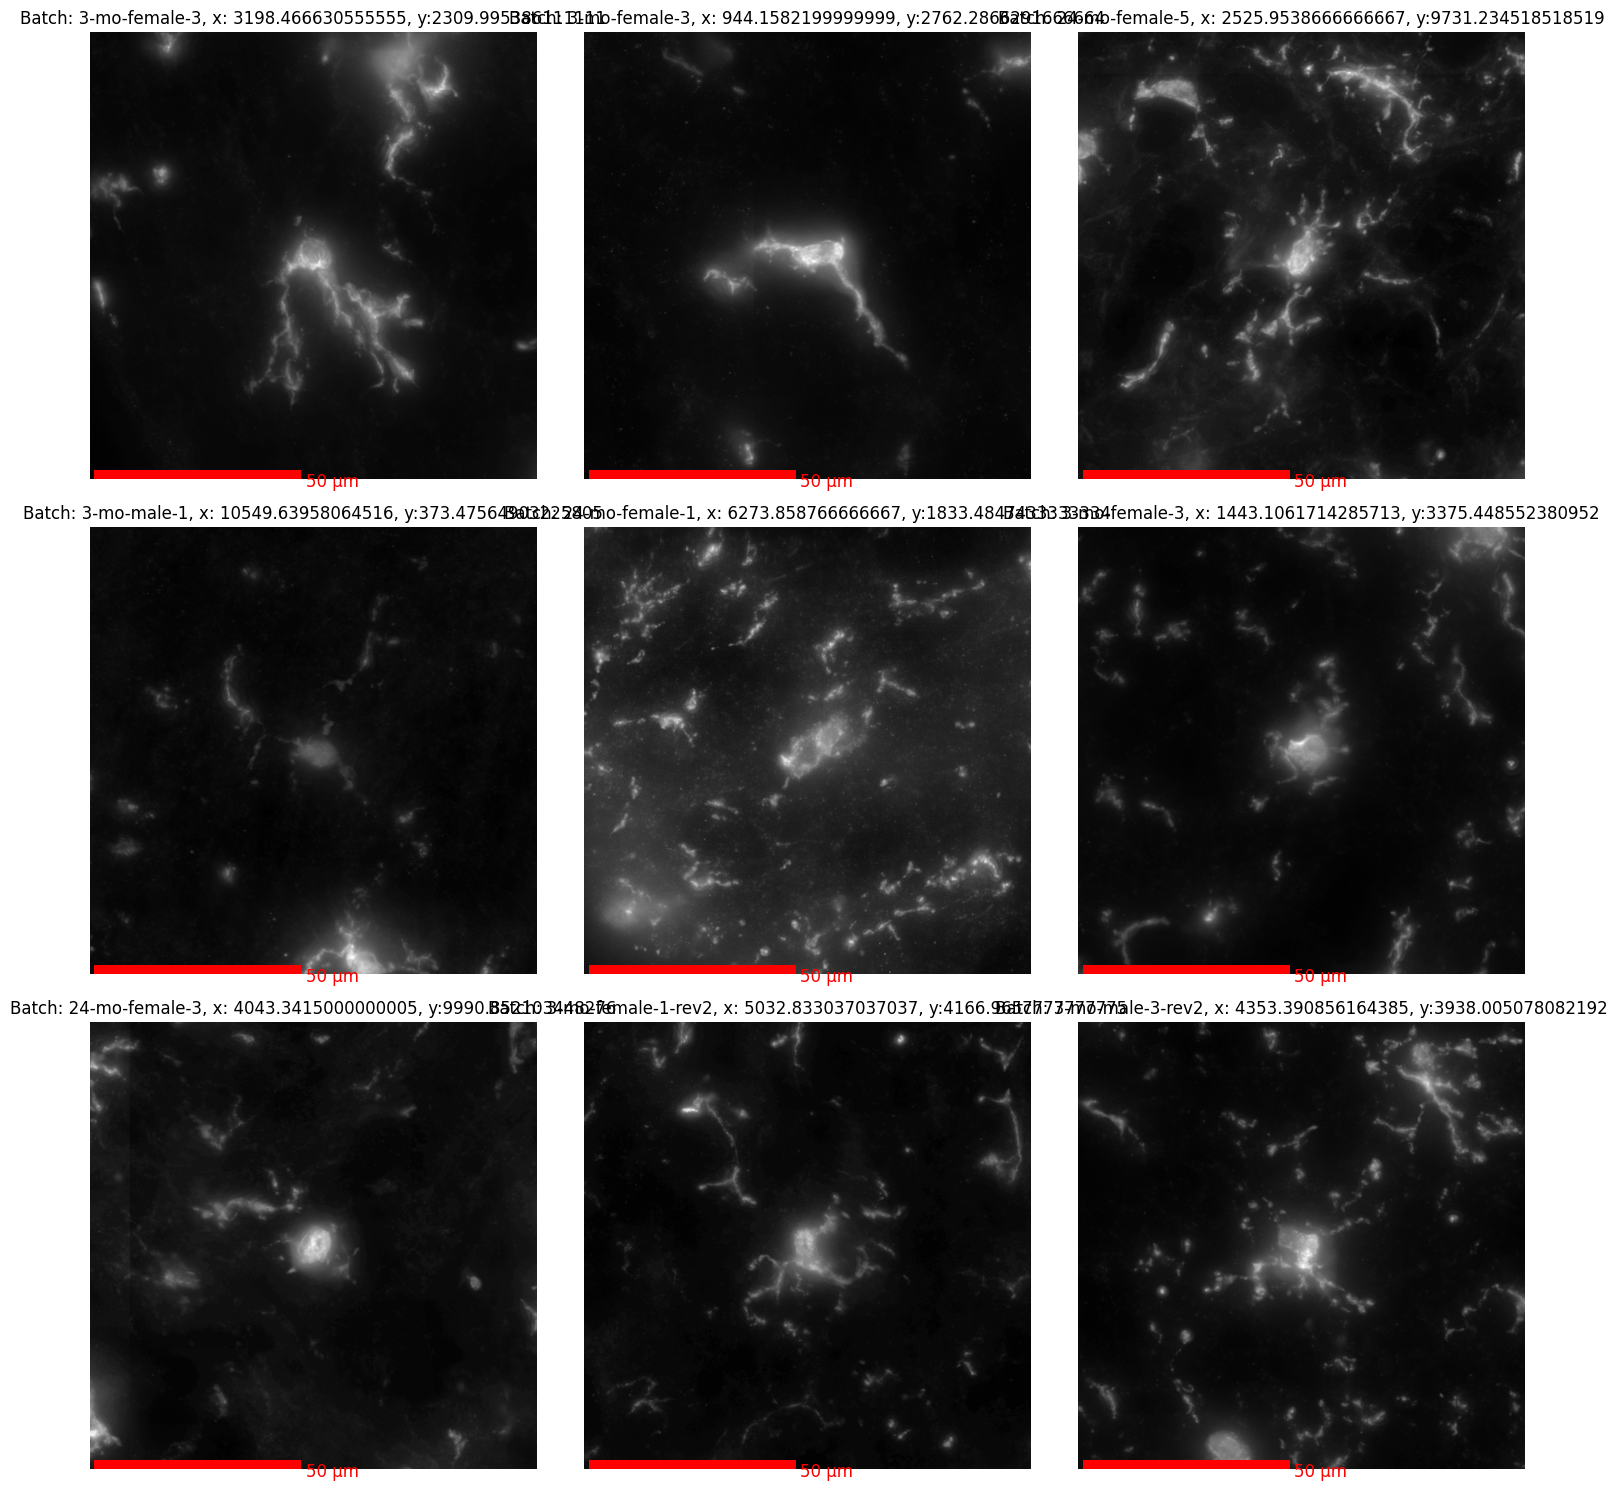

In [22]:
plot_random_cells_from_cluster(new_ad.obs, cluster_id='Transitioning', column='sub_mic', raw=True,conversion_rate=mosaic_to_micron,output_pdf='figures/Transitioning_examples.pdf')

In [32]:
place_in_order = {
    0: '4',
    1: '1',
    2: '2',
    3: '0',
    4: '3',
}

new_ad.obs['ordered_morph'] = new_ad.obs.morph_leiden.map(place_in_order)

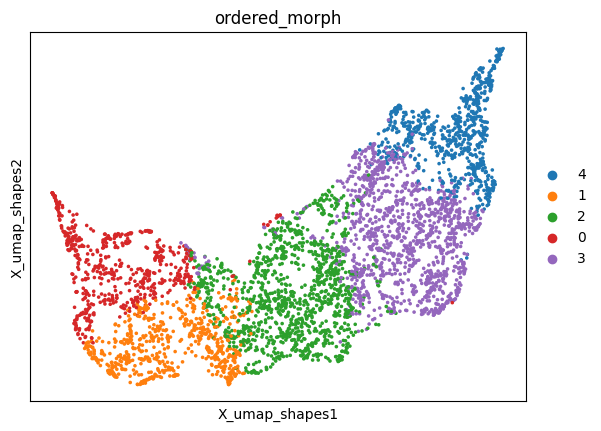

In [33]:
sc.pl.embedding(new_ad, basis='X_umap_shapes',color='ordered_morph')

In [34]:
new_ad.write_h5ad('Transciptomic_labels_and_morphology_labels_full.h5ad')

In [35]:
new_ad

AnnData object with n_obs × n_vars = 4465 × 484
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'ClassP

# Supplemental Figure 2

In [36]:
import scanpy as sc
import pandas as pd
import os
import string
import geopandas as gpd
import numpy as np
from tqdm import tqdm
import Mapping
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
import multiprocessing as mp
from functools import partial
import seaborn as sns

import skimage
import cv2
from skimage.morphology import disk, opening, closing
from scipy.ndimage import binary_fill_holes, label, distance_transform_edt
from skimage.segmentation import find_boundaries, watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops, block_reduce

import anndata
from adjustText import adjust_text

from shapely.geometry import Polygon, shape, box, Point, MultiPolygon
from shapely.affinity import affine_transform, translate
import geopandas as gpd

In [37]:
def find_filtered_transcripts(experiment_path):
    region_types = ['region_0', 'region_1']
    for region in region_types:
        file_path = f'{experiment_path}baysor/detected_transcripts.csv'
        if os.path.exists(file_path):
            return pd.read_csv(file_path,index_col=0)
    return None

def extract_sub_image_with_padding(image, bbox, padding=10):
    min_row, min_col, max_row, max_col = bbox
    min_row = max(min_row - padding, 0)
    min_col = max(min_col - padding, 0)
    max_row = min(max_row + padding, image.shape[0])
    max_col = min(max_col + padding, image.shape[1])
    return image[min_row:max_row, min_col:max_col], (min_row, min_col)

def load_images(batchID, x_ax, y_ax, raw_im, raw_dapi,transcripts, geometries,save_path=None):
    root = '/hpc/projects/group.quake/doug/Shapes_Spatial/'
    
    transform_file = f'{root}{batchID}/images/micron_to_mosaic_pixel_transform.csv'
    transform_df = pd.read_table(transform_file, sep=' ', header=None)
    transformation_matrix = transform_df.values
    
    x_ax = round(x_ax * transformation_matrix[0, 0] + transformation_matrix[0, 2])
    y_ax = round(y_ax * transformation_matrix[1, 1] + transformation_matrix[1, 2])
    
    #print(f'load {batchID}')
    #raw_im = Mapping.load_tiff_image(root + batchID + '/binary_image.tif')
    #dapi_im = Mapping.load_tiff_image(root + batchID + '/images/mosaic_DAPI_z3.tif')
    
    box_size = 500
    x_start = x_ax - box_size
    x_end = x_ax + box_size
    y_start = y_ax - box_size
    y_end = y_ax + box_size
    scaled_geometries = geometries
    
    # Create a box for the small image bounding box
    small_image_box = box(x_start, y_start, x_end, y_end)
    
    # Clip geometries to the bounding box of the small image
    clipped_geometries = [g.intersection(small_image_box) for g in scaled_geometries if g.intersects(small_image_box)]  
    
    # Extract the sub-image, ensuring the indices are within bounds
    sub_image = np.zeros((2 * box_size, 2 * box_size), dtype=raw_im.dtype)
    sub_dapi = np.zeros((2 * box_size, 2 * box_size), dtype=raw_dapi.dtype)
    
    raw_x_start = max(x_start, 0)
    raw_x_end = min(x_end, raw_im.shape[1])
    raw_y_start = max(y_start, 0)
    raw_y_end = min(y_end, raw_im.shape[0])
    
    sub_x_start = max(0, -x_start)
    sub_x_end = sub_x_start + (raw_x_end - raw_x_start)
    sub_y_start = max(0, -y_start)
    sub_y_end = sub_y_start + (raw_y_end - raw_y_start)
    
    sub_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end] = raw_im[raw_y_start:raw_y_end, raw_x_start:raw_x_end]
    sub_dapi[sub_y_start:sub_y_end, sub_x_start:sub_x_end] = raw_dapi[raw_y_start:raw_y_end, raw_x_start:raw_x_end]
    
    transcripts_sub = transcripts.loc[
        (transcripts.mosaic_x < raw_x_end) & (transcripts.mosaic_x > raw_x_start) &
        (transcripts.mosaic_y > raw_y_start) & (transcripts.mosaic_y < raw_y_end)
    ].copy()  # Explicitly create a copy

    # Now assign the new values without triggering the warning
    transcripts_sub['translate_x'] = transcripts_sub.mosaic_x - raw_x_start
    transcripts_sub['translate_y'] = transcripts_sub.mosaic_y - raw_y_start
    
    point_of_interest = Point(x_ax, y_ax)
    
    fig, ax = plt.subplots()
    ax.imshow(sub_image, cmap='gray', extent=(x_start, x_end, y_start, y_end))
    
    for geometry in clipped_geometries:
        if isinstance(geometry, Polygon):
            # Highlight in blue if the geometry contains the point
            color = 'blue' if geometry.contains(point_of_interest) else 'red'
            xs, ys = geometry.exterior.xy
            ax.plot(xs, ys, color=color)
        elif isinstance(geometry, MultiPolygon):
            for poly in geometry.geoms:
                # Highlight in blue if any polygon in MultiPolygon contains the point
                color = 'blue' if poly.contains(point_of_interest) else 'red'
                xs, ys = poly.exterior.xy
                ax.plot(xs, ys, color=color)
    if save_path:
        plt.savefig(save_path,format='pdf')
    plt.show()
    
    return sub_image, sub_dapi, transcripts_sub

def segment_image(im,window_size,foreground=True, dapi=False):
    if im.dtype == 'uint16':
        im = ((im - im.min()) / (im.max() - im.min()) * 255).astype(np.uint8)
    subtract = cv2.fastNlMeansDenoising(im)
    if foreground:
        pre = cv2.adaptiveThreshold((255 - subtract), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, window_size, 2)
    else:
        pre = cv2.adaptiveThreshold((subtract), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, window_size, 2)
    opened = opening(255 - pre, disk(3))
    pre = closing(opened, disk(3))
    filled_image = binary_fill_holes(pre).astype(np.uint8)
        
    return filled_image

def roi_picker(im, point=(500, 500), dapi=False):
    labeled_array, num_features = label(im)
    
    if dapi:
        # Apply distance transform
        distance = distance_transform_edt(labeled_array > 0)
        
        # Generate markers using connected components after thresholding
        coords = peak_local_max(distance, footprint=np.ones((9, 9)), labels=(labeled_array > 0))
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = label(mask)
        # Apply watershed
        watershed_labels = watershed(-distance, markers, mask=(labeled_array > 0))
        
        # Update the labeled array with the watershed labels
        labeled_array = watershed_labels

        # Initialize variables to track the closest region
        closest_region_label = None
        min_distance = float('inf')
        regions = regionprops(labeled_array)

        # Find the closest region to the specified point
        for region in regions:
            if region.area > 500:
                # Calculate the distance from the point to the region's centroid
                region_centroid = np.array(region.centroid)
                distance = np.linalg.norm(region_centroid - np.array(point))

                # Update if this region is closer than previous ones
                if distance < min_distance:
                    min_distance = distance
                    closest_region_label = region.label

        if closest_region_label is not None:
            isolated_component = labeled_array == closest_region_label
            label_image = np.zeros_like(labeled_array)
            label_image[isolated_component] = 1
            return label_image
        else:
            return labeled_array
    else:
        # The original functionality to find the largest region near the point
        largest_component_label = None
        max_area = 0
        regions = regionprops(labeled_array)
        for region in regions:
            if region.area > 500:
                boundary_coords = np.column_stack(np.where(labeled_array == region.label))
                distances = np.linalg.norm(boundary_coords - np.array(point), axis=1)
                min_dist = np.min(distances)

                if min_dist < 50:
                    if region.area > max_area:
                        max_area = region.area
                        largest_component_label = region.label

        if largest_component_label is not None:
            isolated_component = labeled_array == largest_component_label
            label_image = np.zeros_like(labeled_array)
            label_image[isolated_component] = 1
            return label_image
        else:
            return labeled_array
        
def count_gene_overlaps(transcripts, dapi, micro, filled_dapi):
    """
    Counts the occurrences of barcodes (rows) for each gene that overlap with dapi_1, 
    with the binary difference of micro_1 - dapi_1, and with the binary difference of micro_1 - filled_dapi.
    
    Parameters:
        transcripts (pd.DataFrame): A DataFrame containing 'genes', 'translate_x', and 'translate_y' columns.
        dapi_1 (np.array): Binary image representing the region of interest (e.g., DAPI stained area).
        micro_1 (np.array): Binary image representing a larger or different region of interest.
        filled_dapi (np.array): Binary image representing another region of interest.
        
    Returns:
        result (pd.DataFrame): A subset of the input DataFrame 'transcripts' containing only the barcodes that overlap with
                               the binary difference between micro_1 and dapi_1 or the binary difference between 
                               micro_1 and filled_dapi, along with overlap counts per gene.
        dapi_only (pd.DataFrame): A subset of the input DataFrame 'transcripts' containing only the barcodes that overlap exclusively with dapi_1.
    """
    
    transcripts = transcripts.copy()
    # Calculate the differences
    binary_diff_dapi = np.logical_and(micro.astype(bool), np.logical_not(dapi.astype(bool)))
    binary_diff_filled_dapi = np.logical_and(micro.astype(bool), np.logical_not(filled_dapi.astype(bool)))

    # Initialize counts for overlap
    #transcripts['overlap_dapi'] = 0
    #transcripts['overlap_diff_filled_dapi'] = 0

    # Iterate over the transcripts and check for overlap
    #for index, row in transcripts.iterrows():
     #   x, y = int(row['translate_x']), int(row['translate_y'])
     #   if dapi[y, x]:  # Check if the point overlaps with dapi_1
     #       transcripts.at[index, 'overlap_dapi'] = 1
     #   if binary_diff_filled_dapi[y, x]:  # Check if the point overlaps with the binary difference micro_1 - filled_dapi
     #       transcripts.at[index, 'overlap_diff_filled_dapi'] = 1

    # Subset the DataFrame to only include rows where there is an overlap in the desired regions
    #result = transcripts[
     #   (transcripts['overlap_diff_filled_dapi'] > 0) &
      #  (transcripts['overlap_dapi'] == 0)
    #]

    # Group by gene and sum the overlaps

    # Subset the DataFrame to only include rows where there is overlap exclusively with dapi_1
    #dapi_only = transcripts[
     #   (transcripts['overlap_dapi'] > 0) &
     #   (transcripts['overlap_diff_filled_dapi'] == 0)
    #]
    
    results = transcripts[
        (transcripts['translate_x'].astype(int) >= 0) & (transcripts['translate_x'].astype(int) < binary_diff_filled_dapi.shape[1]) &
        (transcripts['translate_y'].astype(int) >= 0) & (transcripts['translate_y'].astype(int) < binary_diff_filled_dapi.shape[0])
    ]

    results = results[
        binary_diff_filled_dapi[results['translate_y'].astype(int), results['translate_x'].astype(int)]
    ]
    
    dapi_only = transcripts[
        (transcripts['translate_x'].astype(int) >= 0) & (transcripts['translate_x'].astype(int) < dapi.shape[1]) &
        (transcripts['translate_y'].astype(int) >= 0) & (transcripts['translate_y'].astype(int) < dapi.shape[0])
    ]

    dapi_only = dapi_only[
        dapi.astype(bool)[dapi_only['translate_y'].astype(int), dapi_only['translate_x'].astype(int)]
    ]
    

    return results, dapi_only

def calculate_areas(dataframe, dapi_labeled_array, non_dapi_labeled_array):
    """
    Calculate the total area of the DAPI (nucleus) and non-DAPI (non-nucleus) regions.

    Parameters:
        dataframe (pd.DataFrame): A DataFrame with one row, which will be used to create the output DataFrame.
        dapi_labeled_array (np.array): A labeled array where each unique integer represents a different object in the nucleus (DAPI).
        non_dapi_labeled_array (np.array): A labeled array where each unique integer represents a different object in the non-nucleus (Non-DAPI).

    Returns:
        result_df (pd.DataFrame): A DataFrame with the same index as the input DataFrame, containing two columns:
                                  'DAPI Area' and 'Non-DAPI Area'.
    """
    
    # Calculate total area for DAPI (nucleus)
    dapi_total_area = sum(region.area for region in regionprops(dapi_labeled_array))
    
    # Calculate total area for Non-DAPI (non-nucleus)
    non_dapi_total_area = sum(region.area for region in regionprops(non_dapi_labeled_array))
    
    # Create a new DataFrame to store the results
    result_df = pd.DataFrame({
        'DAPI Area': [dapi_total_area],
        'Non-DAPI Area': [non_dapi_total_area]
    }, index=dataframe.index)
    
    return result_df

def generate_counts_matrix(dataframe, var_names):
    """
    Generate a counts matrix where columns are genes and rows contain the number of barcodes 
    for that gene present in the dataframe.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame containing barcode information.
        var_names (list or pd.Index): List of gene names (matching adata.var_names).

    Returns:
        pd.DataFrame: A DataFrame with genes as columns and the number of barcodes for each gene.
    """
    # Filter the dataframe to only include genes in var_names
    filtered_df = dataframe[dataframe['gene'].isin(var_names)]
    
    # Count the number of barcodes for each gene
    counts = filtered_df['gene'].value_counts().reindex(var_names, fill_value=0)
    
    # Convert the counts to a DataFrame
    counts_df = counts.to_frame().T
    
    return counts_df

def rename_index(df, adata,blanks):
    counts_matrix_result = generate_counts_matrix(df, adata.var_names.tolist()+blanks)
    counts_matrix_result.index = adata.obs.index
    return counts_matrix_result

def generate_transcript_spreadsheet(transcripts, dapi, micro, ad_test):
    # Calculate the union of dapi_1 and micro_1
    union_mask = np.logical_or(dapi.astype(bool), micro.astype(bool))
    
    #transcripts['overlap'] = 0
    
    #for index, row in transcripts.iterrows():
     #   x, y = int(row['translate_x']), int(row['translate_y'])
     #   if union_mask[y, x]:
      #      transcripts.at[index, 'overlap'] = 1
            
    #filtered_transcripts = transcripts[transcripts.overlap > 0]
    
    

    # Filter transcripts to include only those within the union of dapi_1 and micro_1
    filtered_transcripts = transcripts[
        (transcripts['translate_x'].astype(int) >= 0) & (transcripts['translate_x'].astype(int) < union_mask.shape[1]) &
        (transcripts['translate_y'].astype(int) >= 0) & (transcripts['translate_y'].astype(int) < union_mask.shape[0])
    ]

    filtered_transcripts = filtered_transcripts[
        union_mask[filtered_transcripts['translate_y'].astype(int), filtered_transcripts['translate_x'].astype(int)]
    ]

    # Create a new DataFrame for the spreadsheet
    spreadsheet_df = pd.DataFrame({
        'x': filtered_transcripts['translate_x'].astype(int),
        'y': filtered_transcripts['translate_y'].astype(int),
        'gene': filtered_transcripts['gene'],
        'cell': ad_test.obs.Name.iloc[0]
    })
    return spreadsheet_df

def add_scale_bar(ax, conversion_rate, micron_length, color='red', location=(10, 10), thickness=50, fontsize=12):
    """
    Add a scale bar to the given axis.

    Args:
    - ax: The axis on which to draw the scale bar.
    - conversion_rate: The pixel-to-micron conversion factor (pixels per micron).
    - micron_length: The length of the scale bar in microns.
    - color: The color of the scale bar.
    - location: A tuple specifying the (x, y) location of the scale bar.
    - thickness: The thickness of the scale bar in pixels.
    """
    # Calculate the length of the scale bar in pixels
    pixel_length = conversion_rate * micron_length
    
    # Create a rectangle for the scale bar
    scale_bar = mpatches.Rectangle(location, pixel_length, thickness, linewidth=0, edgecolor=color, facecolor=color)
    
    # Add the scale bar to the plot
    ax.add_patch(scale_bar)
    text_x = location[0] + pixel_length + 10  # Place text to the right of the scale bar
    text_y = location[1] + thickness / 2      # Vertically center the text with the scale bar
    ax.text(text_x, text_y, f'{micron_length} μm', color=color, fontsize=fontsize, va='center')
    
mosaic_to_micron = pd.read_csv('/hpc/projects/group.quake/doug/Shapes_Spatial/3-mo-female-1-rev2/images/micron_to_mosaic_pixel_transform.csv',delimiter=' ').iloc[0,1]

In [38]:
ad_parent = sc.read_h5ad('../03_morph_embedding/Shape_500.h5ad')
ad_parent = ad_parent[ad_parent.obs.updated_celltype == 'Microglia']
experiment = '/hpc/projects/group.quake/doug/Shapes_Spatial/24-mo-female-1/'

batch = experiment.split('/')[-2]
    # We also want to load in the geometry file
ad_viz = ad_parent[ad_parent.obs.batchID == batch]
transform_file = f'{experiment}/images/micron_to_mosaic_pixel_transform.csv'
transform_matrix = pd.read_table(transform_file, sep=' ', header=None).iloc[:2]
transcripts = find_filtered_transcripts(experiment)
transcripts['mosaic_x'], transcripts['mosaic_y'] = transcripts.global_x * transform_matrix.iloc[0,0] + transform_matrix.iloc[0,2], transcripts.global_y * transform_matrix.iloc[1,1] + transform_matrix.iloc[1,2]
blank_names = transcripts[transcripts.gene.str.contains('Blank')].gene.unique().tolist()

root = '/hpc/projects/group.quake/doug/Shapes_Spatial/'
raw_im = Mapping.load_tiff_image(root + batch + '/binary_image.tif')
raw_dapi = Mapping.load_tiff_image(root + batch + '/images/mosaic_DAPI_z4.tif')
raw_polyT = Mapping.load_tiff_image(root + batch + '/images/mosaic_PolyT_z4.tif')
final_df_non_nuc = pd.DataFrame(columns=ad_viz.var_names.tolist()+blank_names)
final_df_nuc = pd.DataFrame(columns=ad_viz.var_names.tolist()+blank_names)
area_df = pd.DataFrame(columns=['DAPI Area','Non-DAPI Area'])
boundaries = gpd.read_parquet(f"{experiment}baysor/region_0_6-5_micron_polygons.parquet")
geometries = boundaries['Geometry']

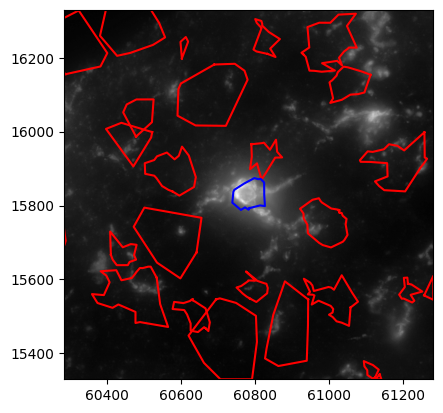

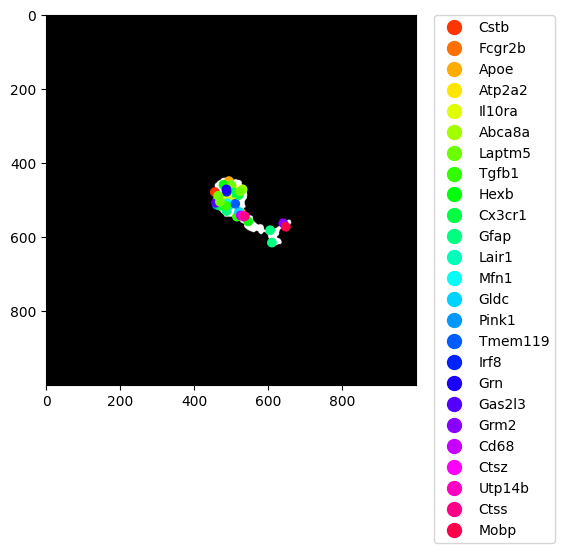

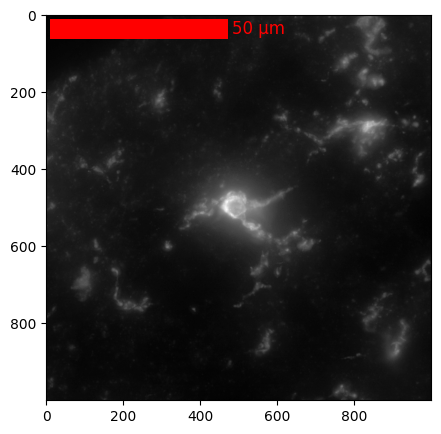

In [41]:
os.makedirs('supp_figures/SI_2', exist_ok=True)
ad_test = ad_viz[ad_viz.obs.morph_leiden == 0][4,:]
small_raw, small_dapi, small_transcripts = load_images(batch, ad_test.obs.x.iloc[0], ad_test.obs.y.iloc[0],raw_im, raw_dapi,transcripts,geometries,save_path='supp_figures/SI_2/mic_1_baysor.pdf')
filled_raw = segment_image(small_raw, 115, foreground=True)
filled_dapi = segment_image(small_dapi, 255, foreground=True, dapi=True)
    
micro_1 = roi_picker(filled_raw)
dapi_1 = roi_picker(filled_dapi,dapi=True)
    
counts_non_nuclei, counts_nuclei = count_gene_overlaps(small_transcripts,dapi_1,micro_1,filled_dapi)
plt.imshow(np.logical_or(dapi_1.astype(bool), micro_1.astype(bool)),cmap='gray')

total_counts = pd.concat([counts_nuclei,counts_non_nuclei])

unique_genes = total_counts['gene'].unique()
color_map = sns.color_palette('hsv', len(unique_genes))  # You can use other color palettes if preferred
gene_to_color = {gene: color_map[i] for i, gene in enumerate(unique_genes)}

# Get the colors for each gene in the DataFrame
colors = total_counts['gene'].map(gene_to_color)

# Plot the background (dapi and micro images)
plt.imshow(np.logical_or(dapi_1.astype(bool), micro_1.astype(bool)), cmap='gray')

# Scatter plot with different colors for each gene
plt.scatter(total_counts['translate_x'], total_counts['translate_y'], c=colors)

# Add a legend (optional)
handles = [plt.Line2D([0], [0], marker='o', color=color_map[i], linestyle='', markersize=10, label=gene) 
           for i, gene in enumerate(unique_genes)]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

os.makedirs('supp_figures/SI_2', exist_ok=True)

plt.savefig('supp_figures/SI_2/mic_1_transcripts.pdf',format='pdf')
# Display the plot
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

ax.imshow(small_raw,cmap='gray')
add_scale_bar(ax, mosaic_to_micron, 50, color='red', location=(10, 10), thickness=50, fontsize=12)
plt.savefig('supp_figures/SI_2/mic_1_raw.pdf',format='pdf')

# Supplemental Figure 3

In [42]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gseapy as gp
from tqdm import tqdm
from adjustText import adjust_text
import seaborn as sns
import anndata

from sklearn.neighbors import BallTree, KDTree
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm
from joblib import delayed, Parallel
import seaborn as sns
import os

from scipy.stats import sem, wilcoxon
from itertools import combinations

In [44]:
def plot_spatial_with_highlight(adata, cell_type_column, cell_type_to_highlight, spatial_key='spatial',save_path=None):
    """
    Plot spatial coordinates of the whole brain, highlighting only a specific cell type.
    
    Parameters:
    - adata: AnnData object with spatial data in `.obsm[spatial_key]`.
    - cell_type_column: Column in `adata.obs` containing cell type annotations.
    - cell_type_to_highlight: The specific cell type to highlight in the plot.
    - spatial_key: The key in `.obsm` for spatial coordinates (default is 'spatial').
    """
    # Extract spatial coordinates
    spatial_coords = adata.obsm[spatial_key]

    # Create a mask for the cells to highlight
    highlight_mask = adata.obs[cell_type_column] == cell_type_to_highlight

    # Plot all cells in grey
    plt.figure(figsize=(20, 8))
    plt.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c='lightgrey', s=5, label='Other cells')

    # Overlay the highlighted cells in a different color (e.g., red)
    plt.scatter(spatial_coords[highlight_mask, 0], spatial_coords[highlight_mask, 1], c='red', s=5, label=cell_type_to_highlight)

    # Add titles and labels
    plt.title(f"Spatial plot highlighting {cell_type_to_highlight}")
    plt.xlabel('Spatial X')
    plt.ylabel('Spatial Y')
    plt.legend()
    if save_path:
        plt.savefig(save_path, dpi=300)

    #plt.gca().invert_yaxis()  # Invert y-axis to match spatial conventions
    plt.show()

def plot_stacked_bar_by_age(adata, age_column='Age', sub_mic_column='sub_mic',output_pdf=None):
    """
    Plot a stacked bar plot showing the percentage of each sub_mic category at each age.
    
    Parameters:
    - adata: AnnData object with `Age` and `sub_mic` information in `.obs`.
    - age_column: The column in `adata.obs` that represents the age (default is 'Age').
    - sub_mic_column: The column in `adata.obs` that represents the sub_mic categories (default is 'sub_mic').
    
    Returns:
    - A stacked bar plot showing the percentage of each sub_mic category at each age.
    """
    # Create a DataFrame with Age and sub_mic information
    df = adata.obs[[age_column, sub_mic_column]]
    
    # Group by Age and sub_mic and count occurrences
    grouped = df.groupby([age_column, sub_mic_column]).size().unstack(fill_value=0)
    
    # Calculate the percentage for each sub_mic category by age
    percentage_df = grouped.div(grouped.sum(axis=1), axis=0) * 100

    # Plot the stacked bar plot
    percentage_df.plot(kind='bar', stacked=True, figsize=(6, 6), cmap='tab20')

    # Customize the plot
    plt.title('Percentage of each sub_mic by Age')
    plt.xlabel('Age')
    plt.ylabel('Percentage')
    plt.legend(title=sub_mic_column, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    if output_pdf:
        plt.savefig(output_pdf,format='pdf')

    # Show the plot
    plt.show()  

def plot_and_export_density_with_stats(adata, adata_total, sub_mic_value, region_column='Brain_Region', age_column='Age', batch_column='batchID', sub_mic_column='sub_mic', output_pdf=None):
    """
    Plot density of a specific sub_mic category and perform pairwise Wilcoxon signed-rank tests between region-age pairs.
    
    Parameters:
    - adata: AnnData object with subset of cells for the sub_mic category.
    - adata_total: AnnData object with all cells for density calculations.
    - sub_mic_value: Specific sub_mic category to analyze.
    - region_column, age_column, batch_column, sub_mic_column: Column names in `.obs`.
    - output_pdf: Path to save plot as a PDF.
    
    Returns:
    - stats_df: DataFrame with density values for plotting.
    - wilcoxon_df: DataFrame with pairwise Wilcoxon signed-rank test results.
    """
    # Filter for cells matching sub_mic_value and get counts by region, age, and batch
    df = adata.obs[[region_column, age_column, batch_column, sub_mic_column]]
    sub_mic_df = df[df[sub_mic_column] == sub_mic_value]
    sub_mic_counts_by_region = sub_mic_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='sub_mic_counts')
    
    # Total cell counts from adata_total for each region, age, and batch
    total_df = adata_total.obs[[region_column, age_column, batch_column]]
    total_counts_by_region = total_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='total_counts')

    # Merge sub_mic counts with total counts and calculate density
    merged_df = pd.merge(sub_mic_counts_by_region, total_counts_by_region, on=[region_column, age_column, batch_column], how='left')
    merged_df['Density'] = merged_df['sub_mic_counts'] / merged_df['total_counts']

    # Calculate mean and SEM for each region and age
    stats_df = merged_df.groupby([region_column, age_column]).agg(
        mean_density=('Density', 'mean'),
        sem_density=('Density', sem)
    ).reset_index()

    # Plot density by region and age
    plt.figure(figsize=(8, 6))
    sns.barplot(data=merged_df, x=region_column, y='Density', hue=age_column, palette='Set2', capsize=0.1, errorbar='se')
    sns.stripplot(data=merged_df, x=region_column, y='Density', hue=age_column, dodge=True, jitter=True, marker='o', palette='dark', size=5, alpha=0.7)
    plt.title(f'Density of {sub_mic_value} in Each Region by Age (Relative to Total Cell Count)')
    plt.xlabel('Region')
    plt.ylabel('Density of Cell Type')
    plt.legend(title='Age')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    if output_pdf:
        plt.savefig(output_pdf, format='pdf')
    plt.show()

    # Perform pairwise Wilcoxon signed-rank tests between each pair of region-age groups
    pairwise_results = []
    merged_df['Density'] = merged_df['Density'].fillna(0)
    unique_pairs = list(combinations(merged_df[[region_column, age_column]].drop_duplicates().itertuples(index=False, name=None), 2))

    for (region1, age1), (region2, age2) in unique_pairs:
        # Extract density values for the two groups
        density_group1 = merged_df[(merged_df[region_column] == region1) & (merged_df[age_column] == age1)]['Density']
        density_group2 = merged_df[(merged_df[region_column] == region2) & (merged_df[age_column] == age2)]['Density']
        
        # Ensure they have matching batch counts for paired testing
        shared_batches = set(merged_df[merged_df[region_column] == region1][batch_column]) & set(merged_df[merged_df[region_column] == region2][batch_column])
        density_group1 = density_group1[merged_df[batch_column].isin(shared_batches)]
        density_group2 = density_group2[merged_df[batch_column].isin(shared_batches)]
        
        # Only conduct test if both groups have values and at least two shared batches
        if len(density_group1) > 1 and len(density_group2) > 1:
            stat, p_value = wilcoxon(density_group1, density_group2)
            pairwise_results.append({
                'Region_Age_1': f"{region1}_{age1}",
                'Region_Age_2': f"{region2}_{age2}",
                'Wilcoxon_statistic': stat,
                'p_value': p_value
            })

    # Convert results to DataFrame
    wilcoxon_df = pd.DataFrame(pairwise_results)
    return stats_df, wilcoxon_df

In [45]:
adata = sc.read_h5ad('../02_annotation/ABC_cleaned.h5ad')
new_ad = sc.read_h5ad('Transciptomic_labels_and_morphology_labels_full.h5ad')

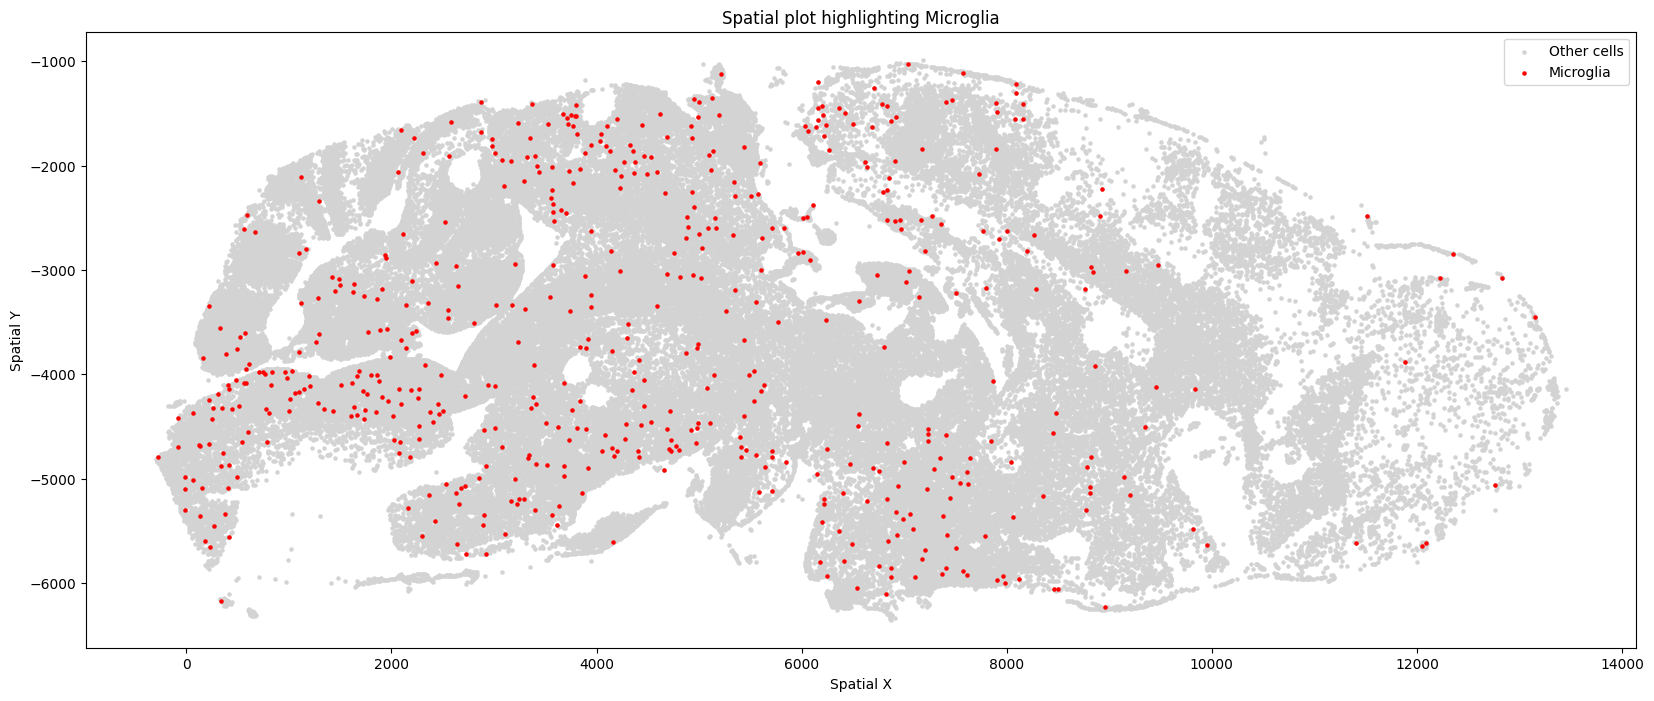

In [46]:
plot_spatial_with_highlight(adata[adata.obs.batchID=='3-mo-male-3-rev2'], cell_type_column='updated_celltype', cell_type_to_highlight='Microglia',save_path='young_microglia_on_brain.png')

In [47]:
new_ad = new_ad[new_ad.obs.Brain_Region != 'Unlabeled']

/tmp/ipykernel_1426461/3146575683.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([age_column, sub_mic_column]).size().unstack(fill_value=0)


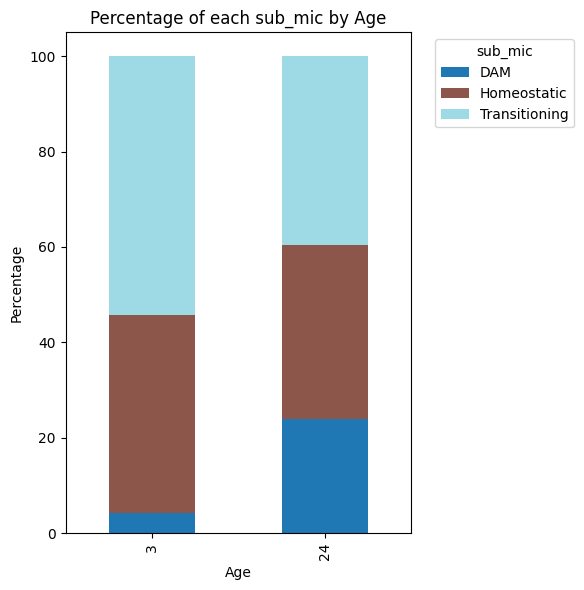

In [48]:
plot_stacked_bar_by_age(new_ad,output_pdf='stacked_bar.pdf')

/tmp/ipykernel_1426461/3146575683.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sub_mic_counts_by_region = sub_mic_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='sub_mic_counts')
/tmp/ipykernel_1426461/3146575683.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts_by_region = total_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='total_counts')
/tmp/ipykernel_1426461/3146575683.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to ret

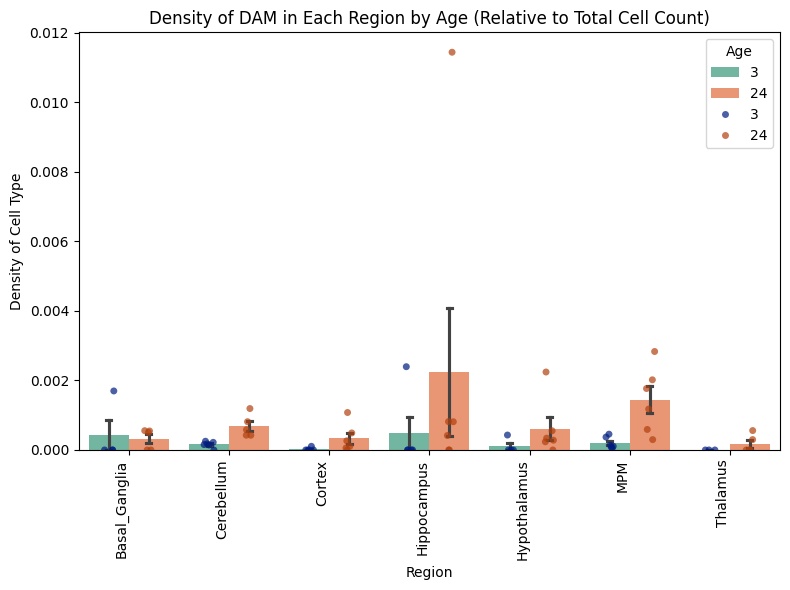

In [50]:
_,pvals = plot_and_export_density_with_stats(new_ad, adata, 'DAM', region_column='Brain_Region', age_column='Age', batch_column='batchID', sub_mic_column='sub_mic', output_pdf='DAM_Microglia_Density.pdf')


/tmp/ipykernel_1426461/3146575683.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sub_mic_counts_by_region = sub_mic_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='sub_mic_counts')
/tmp/ipykernel_1426461/3146575683.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts_by_region = total_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='total_counts')
/tmp/ipykernel_1426461/3146575683.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to ret

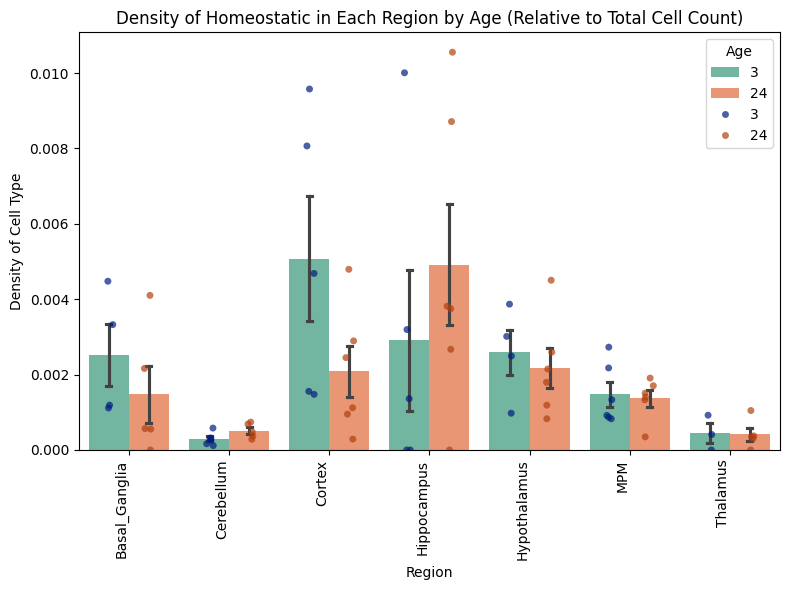

In [52]:
_,pvals = plot_and_export_density_with_stats(new_ad, adata, 'Homeostatic', region_column='Brain_Region', age_column='Age', batch_column='batchID', sub_mic_column='sub_mic', output_pdf='Homeostatic_Microglia_Density.pdf')


/tmp/ipykernel_1426461/3146575683.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sub_mic_counts_by_region = sub_mic_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='sub_mic_counts')
/tmp/ipykernel_1426461/3146575683.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts_by_region = total_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='total_counts')
/tmp/ipykernel_1426461/3146575683.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to ret

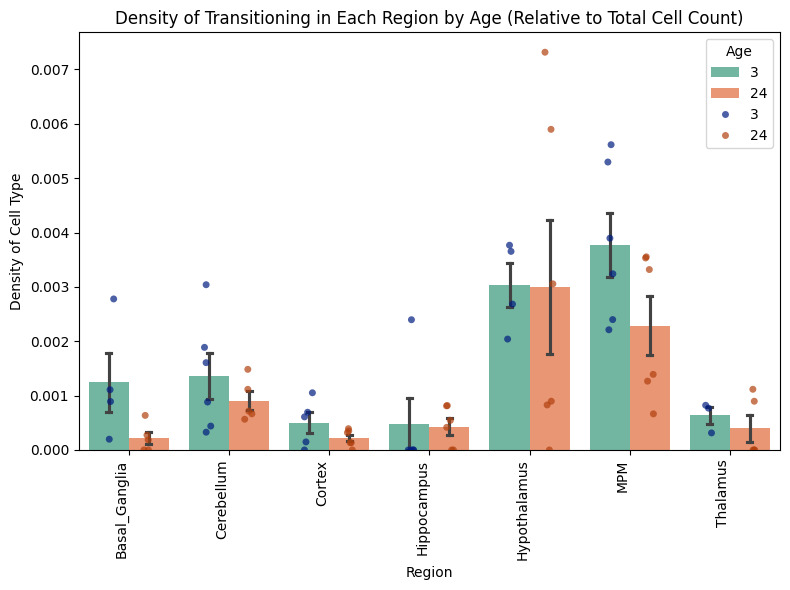

In [53]:
_,pvals = plot_and_export_density_with_stats(new_ad, adata, 'Transitioning', region_column='Brain_Region', age_column='Age', batch_column='batchID', sub_mic_column='sub_mic', output_pdf='Transitioning_Microglia_Density.pdf')


/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


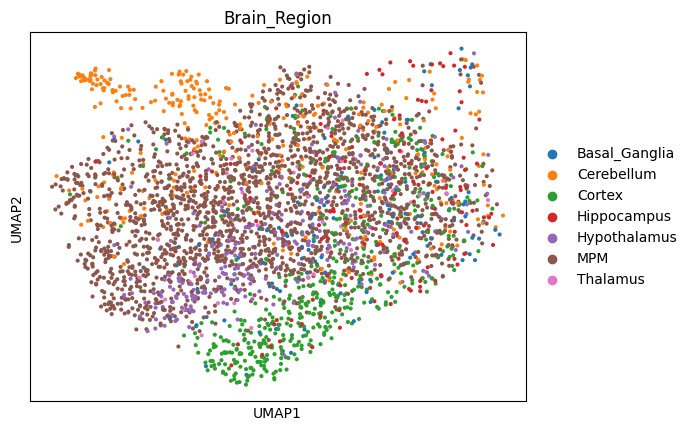

In [54]:
sc.pl.umap(new_ad,color='Brain_Region',save='Region_umap.png')

# Supplemental Figure 4

In [55]:
import seaborn as sns
import scipy.stats as stats
import pandas as pd
from statsmodels.stats.multitest import multipletests

In [56]:
new_ad = sc.read_h5ad('Transciptomic_labels_and_morphology_labels_full.h5ad')

start_index = list(new_ad.obs.columns).index('Cell Area')  # Add 1 to include the column itself
columns_after_specific = new_ad.obs.iloc[:, start_index:].values

morphological_columns = new_ad.obs.columns[start_index:]

features = morphological_columns[:-11].tolist()

features_set = set(features) - set(['Radius of Influence'])
features = [i for i in features_set]

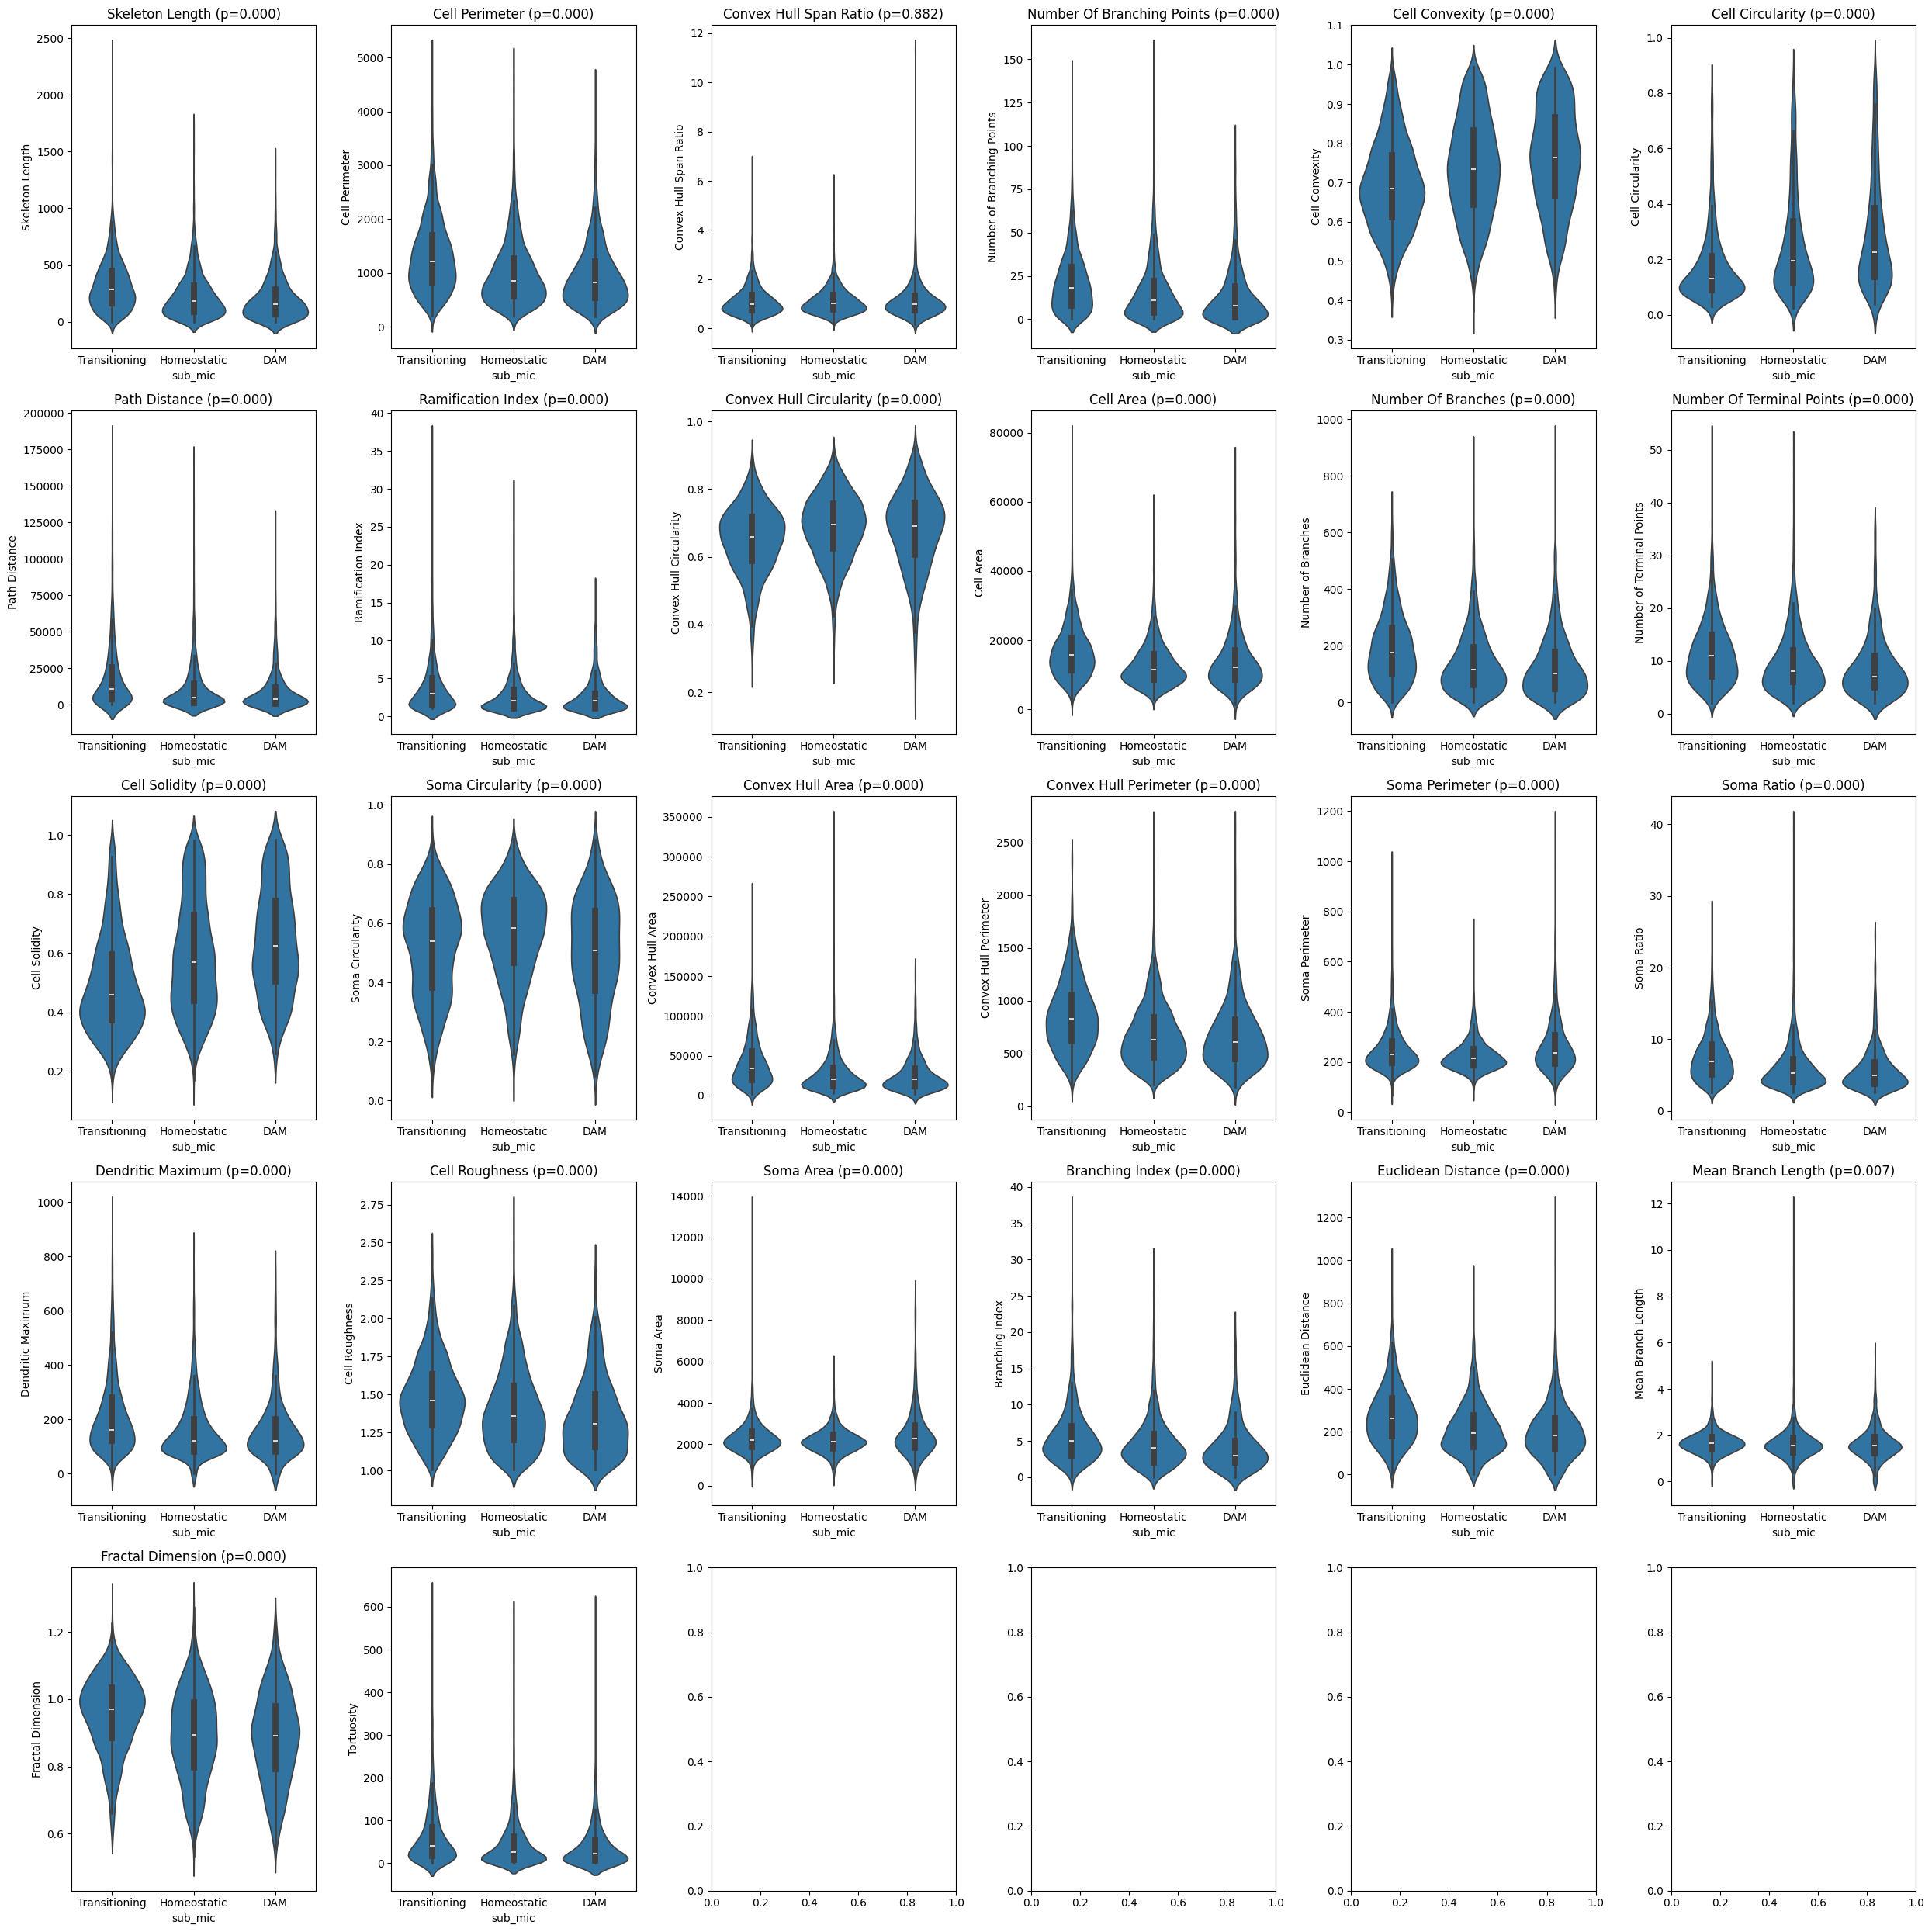

                            F-statistic       p-value  corrected p-value
Skeleton Length              128.666901  4.705741e-55       1.223493e-54
Cell Perimeter               157.404604  8.786526e-67       5.711242e-66
Convex Hull Span Ratio         0.125035  8.824689e-01       8.824689e-01
Number of Branching Points    89.976166  4.911934e-39       8.514019e-39
Cell Convexity               104.449937  4.653903e-45       1.008346e-44
Cell Circularity             162.405209  8.266621e-69       7.164405e-68
Path Distance                 92.180226  5.909977e-40       1.181995e-39
Ramification Index            42.155245  7.352904e-19       7.965646e-19
Convex Hull Circularity       59.260848  3.973929e-26       5.166108e-26
Cell Area                    142.925544  6.846296e-61       2.225046e-60
Number of Branches           138.211843  5.771008e-59       1.667180e-58
Number of Terminal Points     77.682248  6.872145e-34       1.051034e-33
Cell Solidity                219.063905  1.769028e-

In [57]:
custom_order = ['Transitioning', 'Homeostatic', 'DAM']

fig, axes = plt.subplots(5, 6, figsize=(25, 25))  # Adjust grid size as needed
anova_results = {}  # Dictionary to store ANOVA results for each feature

# Collect all p-values to adjust them after loop
all_p_values = []

for i, feature in enumerate(features):
    row = i // 6
    col = i % 6
    y_feature = feature  # The y-axis feature to plot

    # Apply the custom order to the 'sub_mic' column in the violin plot
    sns.violinplot(x='sub_mic', y=y_feature, data=new_ad.obs, ax=axes[row, col], inner='box', order=custom_order)
    
    # Perform ANOVA
    groups = [new_ad.obs[new_ad.obs['sub_mic'] == cluster][y_feature].dropna() for cluster in custom_order]
    f_stat, p_value = stats.f_oneway(*groups)  # ANOVA calculation
    
    # Store the initial result and save the p-value for multiple testing correction
    anova_results[feature] = {'F-statistic': f_stat, 'p-value': p_value}
    all_p_values.append(p_value)

# Apply multiple testing correction to all p-values
_, corrected_p_values, _, _ = multipletests(all_p_values, method='fdr_bh')  # Benjamini-Hochberg (FDR) correction

# Update anova_results with corrected p-values
for i, feature in enumerate(features):
    anova_results[feature]['corrected p-value'] = corrected_p_values[i]

    # Update plot titles to include corrected p-value
    row = i // 6
    col = i % 6
    if i < 25:  # To ensure we don't exceed subplot limits
        axes[row, col].set_title(f"{feature.replace('_', ' ').title()} (p={corrected_p_values[i]:.3f})")

# Save the plot
plt.tight_layout()
plt.savefig('figures/morphology_by_cluster_custom_order_rotated_labels.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Optionally, display or save the ANOVA results
anova_df = pd.DataFrame(anova_results).T  # Convert to DataFrame for easy viewing
print(anova_df) 